## โหลดรูปเบื้องต้น

In [1]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

def face_detection(gray_img):
    face_cascade = cv2.CascadeClassifier('experiment_and_research/files/haarcascade_frontalface_default.xml')

    #จำแนกใบหน้า
    scaleFactor = 1.1
    minNeighber = 12
    face_detect = face_cascade.detectMultiScale(gray_img, scaleFactor, minNeighber)

    expand_ratio = 0.6  # อัตราส่วนการขยาย (50% ของขนาดเดิม)
    for (x, y, w, h) in face_detect:
        # คำนวณขนาดขยาย
        x_exp = int(x - expand_ratio * w)
        y_exp = int(y - expand_ratio * h)
        w_exp = int(w + 2 * (expand_ratio) * w)
        h_exp = int(h + 2 * (expand_ratio+0.3) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(gray_img.shape[1] - x_exp, w_exp)
        h_exp = min(gray_img.shape[0] - y_exp, h_exp)

        # วาดกรอบ
        cv2.rectangle(gray_img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (128, 128, 128), thickness=-1)
        cv2.imwrite("../data/output_images/output/face_remove.jpg", gray_img)

    return gray_img

# โหลดภาพ
#image = cv2.imread("../data/test_images/transcript/pun_20240817_0001.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_f.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_no_f.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_tran_mo.jpg")
#image = cv2.imread("../data/test_images/word_images/test2.png")
#image = cv2.imread("../data/test_images/transcript/Transcript2.jpg")
image = cv2.imread("../data/test_images/word_images/word_34.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_img = face_detection(gray)


# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 61,40
    #gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51,12
)

# ใช้ Otsu Thresholding
#_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((6, 80), np.uint8)
lines = cv2.dilate(binary_image, kernel, iterations=1)

cv2.imwrite("../data/output_images/output/gary.jpg", gray)
cv2.imwrite("../data/output_images/output/binary.jpg", binary_image)
cv2.imwrite("../data/output_images/output/line.jpg", lines)

#kernel = np.ones((3,9), np.uint8)
dilalated_line_img = cv2.dilate(binary_image, kernel, iterations=1)

cv2.imwrite("../data/output_images/output/original.jpg", image)

True

# จับกลุ่มข้อความ

0
1
2


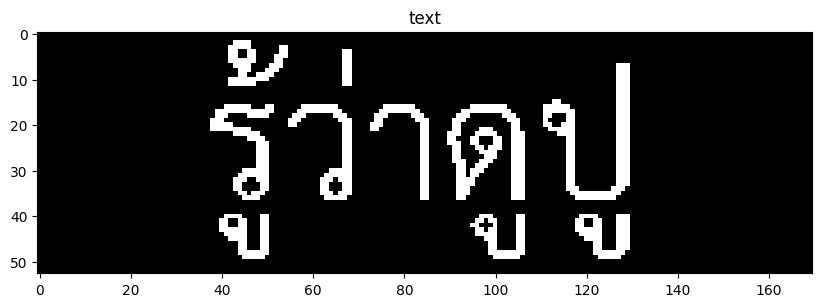

In [2]:
def detect_text_group(dilalated_image, binary_image):

    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]


    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    #for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        #x, y, w, h, area = stats[i]
        x, y, w, h, area = stats

        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        if w >= 90 and h >= 20:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            cv2.imwrite(f"../data/output_images/output/cca_{idx}.jpg", cca_img)
            cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return text_group_images

text_group_images = detect_text_group(dilalated_line_img, binary_image)

for idx, text_group in enumerate(text_group_images):
    print(idx)


cv2.imwrite("../data/output_images/output/cca.jpg", image)
print(len(text_group_images))

plt.figure(figsize=(10,10))
plt.imshow(text_group_images[0], cmap="gray")
plt.title(f"text")
plt.show()


## จับข้อความย่อยในกลุ่มข้อความ

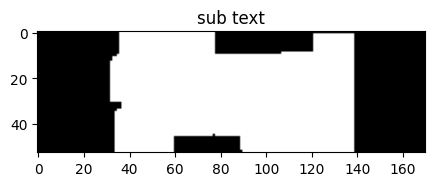

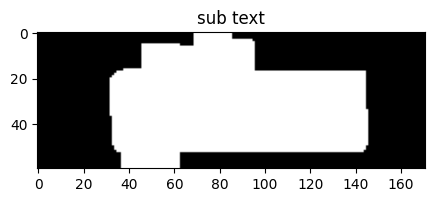

จำนวนกลุ่มข้อความ: 2
 จำนวนข้อความย่อยในกลุ่มข้อความ: 1


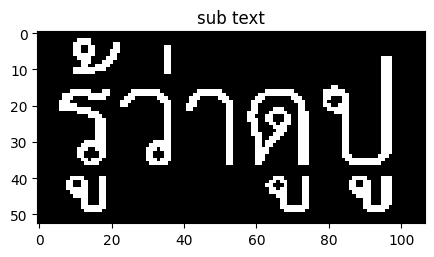

In [3]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def detect_text_in_group(binary_image):
    kernel = np.ones((6, 6), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=3)

    plt.figure(figsize=(5,5))
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"sub text")
    plt.show()

    sub_text_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    #for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
    for idx, stats in enumerate(sorted_stats):
        #x, y, w, h, area = stats[i]
        x, y, w, h, area = stats
        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
        sub_text_images.append(cca_img)
        cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return sub_text_images 

#text_images = detect_text_in_group(dilalated_img, binary_image)

text_group_sub_images = []
for idx_text, text_group in enumerate(text_group_images):
    #print(idx_text)
    text_group_sub_images.append(detect_text_in_group(text_group))

print("จำนวนกลุ่มข้อความ:", len(text_group_sub_images)) 
print(" จำนวนข้อความย่อยในกลุ่มข้อความ:", len(text_group_sub_images[0]))  

'''
plt.figure(figsize=(2,2))
plt.imshow(text_group_sub_images[0][0], cmap="gray")
plt.title(f"text")
plt.show()
'''

for idx, sub_text  in enumerate(text_group_sub_images[0]):
    plt.figure(figsize=(5,5))
    plt.imshow(sub_text, cmap="gray")
    plt.title(f"sub text")
    plt.show()



## จับตัวอักษร

กลุ่มข้อความที่: 1
   ข้อความย่อยที่: 1
สลับตำแหน่ง
max_area : index 1


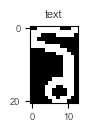

area : 107
level: 1


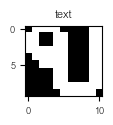

area : 59
level: 0


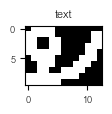

area : 66
level: 2
Sum fo area: 232
Number of characters detected: 3
มีตัวเดียว


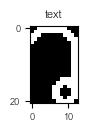

area : 86
level: 1


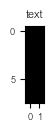

area : 16
level: 2
Sum fo area: 102
Number of characters detected: 2


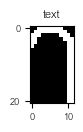

area : 64
level: 1
Sum fo area: 64
Number of characters detected: 1
สลับตำแหน่ง
max_area : index 1


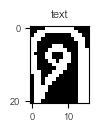

area : 159
level: 1


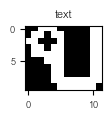

area : 56
level: 0
Sum fo area: 215
Number of characters detected: 2
สลับตำแหน่ง
max_area : index 1


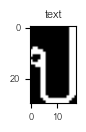

area : 161
level: 1


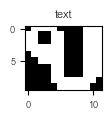

area : 67
level: 0
Sum fo area: 228
Number of characters detected: 2
กลุ่มข้อความที่: 2
   ข้อความย่อยที่: 1
สลับตำแหน่ง
max_area : index 1


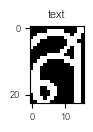

area : 153
level: 1


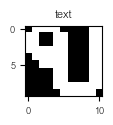

area : 59
level: 0


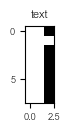

area : 17
level: 2
Sum fo area: 229
Number of characters detected: 3
มีตัวเดียว


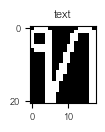

area : 141
level: 1


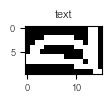

area : 69
level: 2


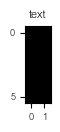

area : 12
level: 3
Sum fo area: 222
Number of characters detected: 3


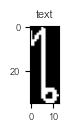

area : 110
level: 1
Sum fo area: 110
Number of characters detected: 1


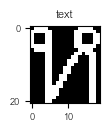

area : 146
level: 1
Sum fo area: 146
Number of characters detected: 1


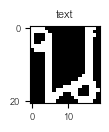

area : 136
level: 1
Sum fo area: 136
Number of characters detected: 1


In [27]:
import numpy as np
from sklearn import dummy
from sympy import false, true

def percentage_difference(value1, value2):
    return abs(value1 - value2) / value1 * 100

def sort_and_swap(stats):

    if(len(stats) > 1):
        """
        จัดเรียงข้อมูลใน stats โดยเรียงจาก y + h (มากไปน้อย)
        และตรวจสอบว่าข้อมูลที่มี area ใหญ่ที่สุดอยู่ในตำแหน่งแรกสุดหรือไม่
        """
        # คำนวณค่า y + h สำหรับการจัดเรียง
        stats_with_indices = [(i, stat) for i, stat in enumerate(stats)]
        stats_with_indices.sort(key=lambda x: x[1][1] + x[1][3], reverse=True)  # y + h (มาก -> น้อย)

        # สร้างลิสต์ใหม่หลังการจัดเรียง
        sorted_stats = [stat for _, stat in stats_with_indices]
        sorted_stats = np.array(sorted_stats)

        # หาค่า area ที่ใหญ่ที่สุดและตำแหน่ง
        areas = [stat[4] for stat in sorted_stats]  # ค่า area อยู่ใน index ที่ 4
        max_area = max(areas)
        max_area_index = areas.index(max_area)

        # กรองเอา noise ออกโดยเทียบกับ area ที่ใหญ่ที่สุด
        sorted_stats_noise_remove = []
        for stat in (sorted_stats):
            difference = percentage_difference(max_area, stat[4])
            #print("Max Area :", max_area)
            #print("Difference :", difference)
            if(difference < 95):
               sorted_stats_noise_remove.append(stat)
        sorted_stats = np.array(sorted_stats_noise_remove)
        
        # สร้างคอลัมน์ใหม่ที่มีค่าเริ่มต้นจาก 0 และเพิ่มทีละ 1
        rows = sorted_stats.shape[0]  # จำนวนแถว
        new_column = np.arange(rows).reshape(-1, 1)  # คอลัมน์ [0, 1, 2, ...]

        # เพิ่มคอลัมน์ใหม่เข้าไปใน array เดิม
        sorted_stats = np.hstack((sorted_stats, new_column))

        # หาค่า area ที่ใหญ่ที่สุดและตำแหน่ง
        areas = [stat[4] for stat in sorted_stats]  # ค่า area อยู่ใน index ที่ 4
        max_area = max(areas)
        max_area_index = areas.index(max_area)
    
        # ตรวจสอบว่า area ที่ใหญ่ที่สุดอยู่ตำแหน่งแรกหรือไม่
        if max_area_index != 0:
            # สลับตำแหน่งตัวที่มี area ใหญ่ที่สุดกับตัวแรก
            print("สลับตำแหน่ง")
            print("max_area : index", max_area_index)
            sorted_stats[[0, max_area_index]] = sorted_stats[[max_area_index, 0]]
            #sorted_stats[0], sorted_stats[max_area_index] = sorted_stats[max_area_index], sorted_stats[0]

        #ในกรณี "มีตัวเดียว"
        elif max_area_index == 0:
            print("มีตัวเดียว")
            sorted_stats[:, -1]+=1

        #ในกรณีสระ "อะ"
        if (len(sorted_stats) == 2):
            difference = percentage_difference(sorted_stats[0][4], sorted_stats[1][4])
            #print(difference)
            if(difference <= 8):
                sorted_stats[0][-1] = 2
                sorted_stats[1][-1] = 2

        return sorted_stats
    else:
        new_values = [1]  # ต้องมีจำนวนเท่ากับจำนวนแถว

        # เพิ่มเลขในตำแหน่งสุดท้ายของทุกแถว
        new_values_column = np.array(new_values).reshape(-1, 1)  # แปลงเป็นคอลัมน์
        stats = np.hstack([stats, new_values_column])

        return stats

def char_level(char_image):
    debug = True  # ตั้งค่าเปิด/ปิด Debug

    kernel = np.ones((1, 1), np.uint8)
    #dummy_image = cv2.dilate(char_image, kernel, iterations=1)
    dummy_image = cv2.erode(char_image, kernel, iterations=1)

    #plt.figure(figsize=(1,1))
    #plt.imshow(dummy_image, cmap="gray")
    #plt.title(f"text")
    #plt.show()
    

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(char_image, connectivity=8)
    sorted_stats = sort_and_swap(stats[1:])
    char_level_group = []

    sum_area = 0
    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background

        x, y, w, h, area, level = stats

        sum_area += area

        # กรอง noise หรือส่วนที่ไม่ใช่ข้อความ
        if w <= 2 and h <= 2:  # ปรับค่าตามความเหมาะสม
            print("เล็กเกินข้าม")
            #print(area)
            #continue

        cca_img = char_image[y:y+h, x:x+w]
        char_level_group.append([cca_img, level])
        #cv2.imwrite(f"../data/test_images/char_level/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"../data/test_images/char_level/dummy_image.jpg", dummy_image)
        
        if debug:
            plt.figure(figsize=(1,1))
            plt.imshow(cca_img, cmap="gray")
            plt.title(f"text")
            plt.show()
            print("area :" ,area)
            print("level:", level)

    print(f"Sum fo area: {sum_area}")
    print(f"Number of characters detected: {len(char_level_group)}")
    return char_level_group 

#cv2.imwrite(f"../data/test_images/char_level/cca.jpg", image)

def detect_char(binary_image):
    debug = False  # ตั้งค่าเปิด/ปิด Debug

    kernel = np.ones((1, 1), np.uint8)
    kernel_2 = np.ones((10, 1), np.uint8)
    kernel_3 = np.ones((2, 2), np.uint8)

    #dummy_image = cv2.erode(binary_image, kernel, iterations=1)
    #dummy_image = cv2.dilate(dummy_image, kernel_2, iterations=1)

    # การทำ Opening
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_3, iterations=1)
    dummy_image = cv2.dilate(opened, kernel_2, iterations=1)


    #plt.figure(figsize=(5, 5))
    #plt.imshow(dummy_image, cmap="gray")
    #plt.title(f"dummy_image")
    #plt.show()

    char_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    for idx, stat in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stat
        #print("area : ",area)

        # ตัดภาพใน Bounding Box
        cca_img = binary_image[y:y+h, x:x+w]
        #cca_img = binary_image[:, x:x+w]

        if debug:
            plt.figure(figsize=(1, 1))
            plt.imshow(cca_img, cmap="gray")
            plt.title(f"Character {idx}")
            plt.show()

        # ใช้ฟังก์ชัน char_level เพื่อแยกตัวอักษรย่อย
        char_leveled = char_level(cca_img)

        # รวมตัวอักษรย่อยในรายการ
        char_images.extend(char_leveled)
        #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    return char_images 

text_group_sub_char_images = []
for idx_group, text_group in enumerate(text_group_sub_images):
    print("กลุ่มข้อความที่:", idx_group+1)

    char_in_sub_text = []
    for idx_sup, sub_text in enumerate(text_group):
        print("   ข้อความย่อยที่:", idx_sup+1)
        char_images = detect_char(sub_text)
        char_in_sub_text.append(char_images)
        
        #for idx_char, char in enumerate(sub_text):
        #   print("    อักษรที่:", idx_char+1)

    text_group_sub_char_images.append(char_in_sub_text)





In [ ]:
#print("จำนวนกลุ่มข้อความ:", len(text_group_sub_char_images)) 
#print(" จำนวนข้อความย่อยในกลุ่มข้อความ:", len(text_group_sub_char_images[0]))
#print("    จำนวนตัวอักษรในข้อความย่อย:", len(text_group_sub_char_images[0][0]))
#print("       ตัวอักษรและ level:", len(text_group_sub_char_images[0][0][0]))
#print("           level:", text_group_sub_char_images[0][0][0][1])


'''
plt.figure(figsize=(1,1))
plt.imshow(text_group_sub_char_images[0][0][0], cmap="gray")
plt.title(f"text")
plt.show()
'''

#print(len(text_group_sub_char_images[0][0]))

for idx, char in enumerate(range(0, len(text_group_sub_char_images[1][0]))): # ข้อความ, ข้อความย่อยม, รูปภาพกับlevel,
    #print(idx)
    plt.figure(figsize=(1,1))
    plt.imshow(text_group_sub_char_images[1][0][idx][0], cmap="gray")
    print("level :", text_group_sub_char_images[1][0][idx][1])
    plt.show()

'''
for idx, img in enumerate(char):
        print(img)
        plt.figure(figsize=(1,1))
        plt.imshow(img[idx][0], cmap="gray")
        plt.title(f"text")
        plt.show()
'''

'''
for idx, char in enumerate(text_group_sub_char_images[1][0]):
    plt.figure(figsize=(1,1))
    plt.imshow(char, cmap="gray")
    cv2.imwrite(f"../data/output_images/noise/noise_{idx}.jpg", char)
    plt.title(f"text")
    plt.show()
'''



## Predict images with Multiple models

In [5]:
from tensorflow.keras.models import load_model

model_path = "../models/thai_and_numerals_model.h5"
model = load_model(model_path)

model_path_char_level_0 = "../models/char_level_0_model.h5"
model_path_char_level_1 = "../models/char_level_1_model.h5"
model_path_char_level_2 = "../models/char_level_2_model.h5"
model_path_char_level_3 = "../models/char_level_3_model.h5"

model_char_level_0 = load_model(model_path_char_level_0)
model_char_level_1 = load_model(model_path_char_level_1)
model_char_level_2 = load_model(model_path_char_level_2)
model_char_level_3 = load_model(model_path_char_level_3)

# สร้าง Mapping ของโมเดลตามระดับ
models = {
    0: model_char_level_0,
    1: model_char_level_1,
    2: model_char_level_2,
    3: model_char_level_3,
}


1/1 [==============================] - 0s 15ms/step
Predicted Letter: ร, Confidence: 1.00
Predicted Letter: ู, Confidence: 0.83
Predicted Letter: ้, Confidence: 1.00
Predicted Letter: ว, Confidence: 1.00
Predicted Letter: ่, Confidence: 1.00
Predicted Letter: า, Confidence: 1.00
Predicted Letter: ด, Confidence: 0.99
Predicted Letter: ู, Confidence: 1.00
Predicted Letter: ป, Confidence: 1.00
Predicted Letter: ู, Confidence: 1.00
Predicted Letter: ส, Confidence: 1.00
Predicted Letter: ู, Confidence: 0.83
Predicted Letter: ่, Confidence: 1.00
Predicted Letter: ท, Confidence: 1.00
Predicted Letter: ี, Confidence: 1.00
Predicted Letter: ่, Confidence: 1.00
Predicted Letter: ไ, Confidence: 0.90
Predicted Letter: ห, Confidence: 1.00
Predicted Letter: น, Confidence: 1.00
Character 0: Predicted Label = ร (100.00%)
Character 1: Predicted Label = ู (82.96%)
Character 2: Predicted Label = ้ (100.00%)
Character 3: Predicted Label = ว (100.00%)
Character 4: Predicted Label = ่ (100.00%)
Character 5:

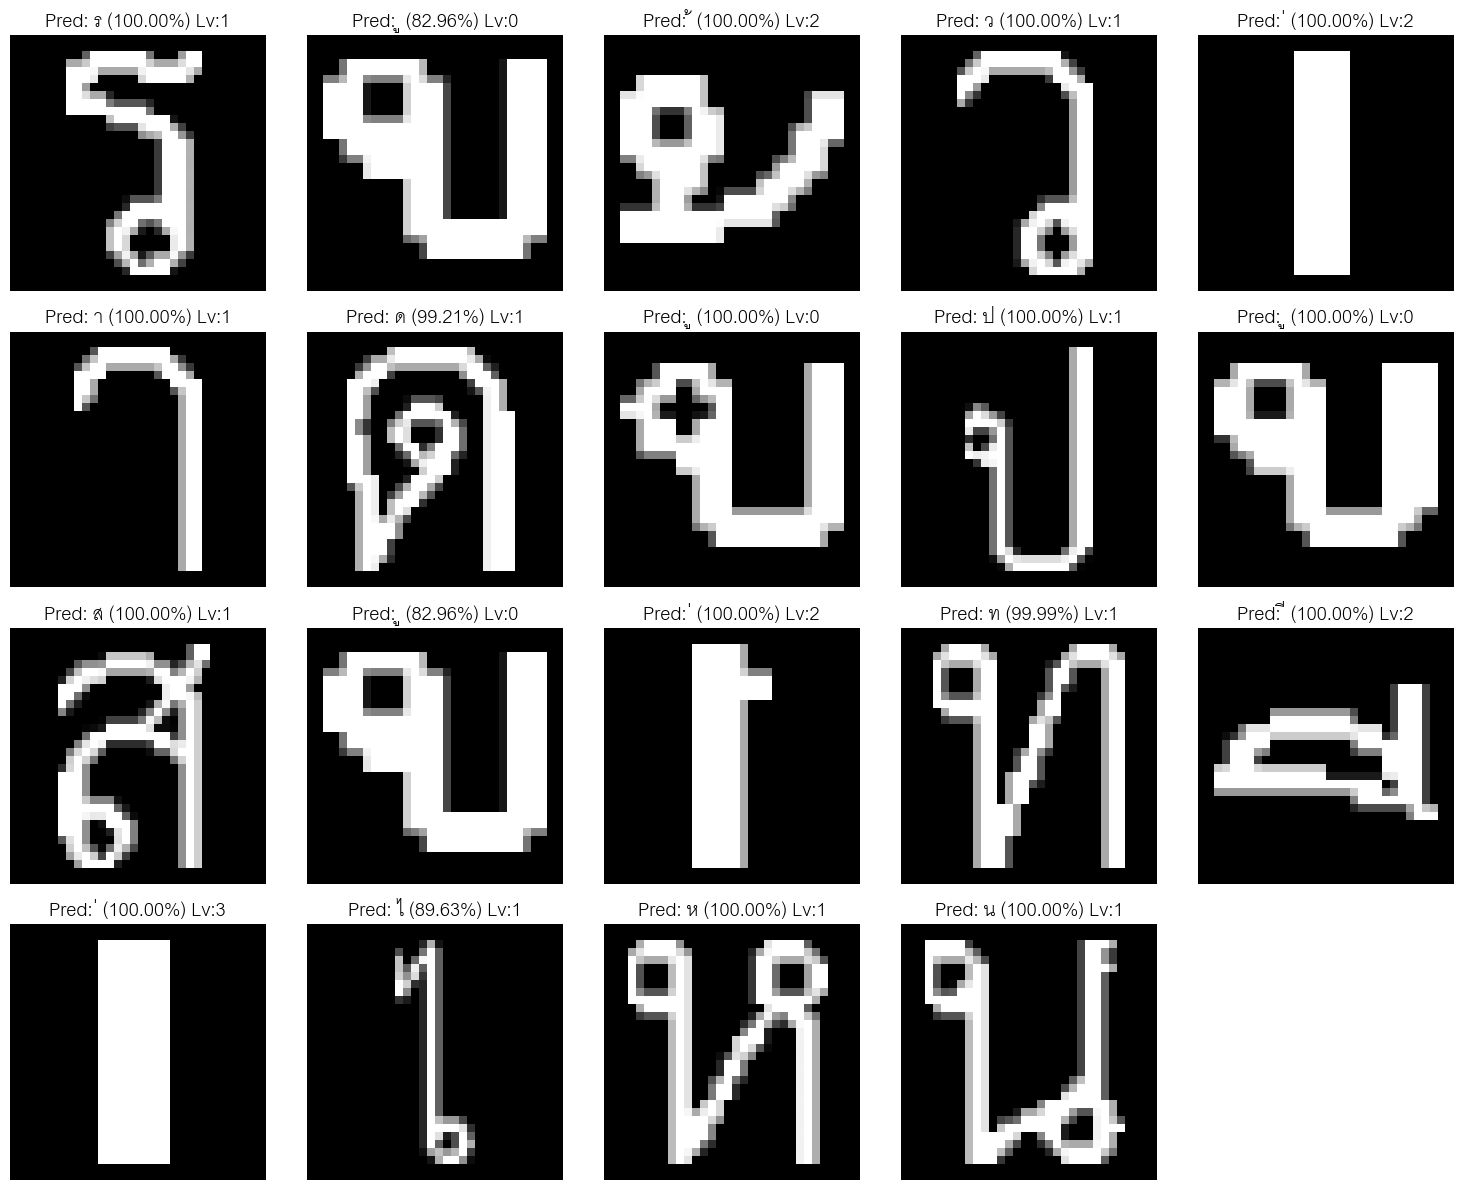

In [28]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

thai_and_numerails_special_characters = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'ะ', 'า', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'โ', 'ฤ', 'ใ', 'ไ', '็', 
    'ั', 'ํ',

    '่', '้', '๊', '๋',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_0_label = [
    'ุ', 'ู'
]

char_level_1_label = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'า', 'เ', 'โ', 'ฤ', 'ใ', 'ไ',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_2_label = [
     'ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋',
]

char_level_3_label = [
    '่', '้', '๊', '๋',
]

char_level_labels = {
    0: char_level_0_label,
    1: char_level_1_label,
    2: char_level_2_label,
    3: char_level_3_label,
}

letters_class = thai_and_numerails_special_characters

def resize_with_min_padding(image, desired_size, min_padding):
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image


# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []
char_levels = []


text_block = []
for idx_text_group, text_group in enumerate(text_group_sub_char_images):
    #print("กลุ่มข้อความ", idx_text_group+1)
    for idx_text_sub, text_sub in enumerate(text_group):
        #print("  ข้อความย่อยในกลุ่มข้อความ", idx_text_sub+1)
        for idx_char, char in enumerate(text_sub):
            char_image, char_level = char
            if char is None:
                print(f"Character image {idx_char} is None.")
                continue  # ข้ามภาพนี้
            else:
                #plt.figure(figsize=(1,1))
                #plt.imshow(char_img, cmap="gray")

                # เพิ่ม Padding และปรับขนาดภาพ
                padded_img = resize_with_min_padding(char_image, input_size, min_padding=2)

                # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                normalized_img = padded_img / 255.0

                # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
                if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                    normalized_img = np.expand_dims(normalized_img, axis=-1)

                    # เก็บภาพที่ประมวลผลแล้ว
                    processed_images.append(normalized_img)

                    # เก็บ level ของตัวอักษร
                    char_levels.append(char_level)

# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

def predict_character_levels(processed_images, char_levels, models):
    predictions = []
    current_char_levels = []

    for idx, processed_img in enumerate(processed_images):
        level = char_levels[idx]
        if level in models:
            predictions.append(models[level].predict(np.expand_dims(processed_img, axis=0)))
            current_char_levels.append(level)
        else:
            print("ผิด")
            print(level)
            predictions.append(models[3].predict(np.expand_dims(processed_img, axis=0)))
            current_char_levels.append(3)
            #print(f"Warning: ไม่มีโมเดลสำหรับระดับ {level}. ข้ามภาพนี้ไป.")

    return predictions, current_char_levels
        
def predicted_classes_confidence(predictions_result):

    predicted_classes_group = []
    confidence_scores_group = []
    for idx, result in enumerate(predictions_result):
        predicted_classes = np.argmax(result, axis=1)
        confidence_scores = np.max(result, axis=1)
        #print("Predicted classes :",predicted_classes)
        #print("Confidence scores :",confidence_scores)

        predicted_classes_group.extend(predicted_classes)
        confidence_scores_group.extend(confidence_scores)

    return predicted_classes_group, confidence_scores_group

        
# เรียกใช้งานฟังก์ชัน
predictions, current_char_levels = predict_character_levels(processed_images, char_levels, models)
predicted_classes, confidence_scores = predicted_classes_confidence(predictions)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
#predicted_classes = np.argmax(predictions, axis=1)
#confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

for i, pred_class in enumerate(predicted_classes):
    class_level = current_char_levels[i]
    letters_class = char_level_labels[class_level]

    predicted_letter = letters_class[pred_class]  # แปลงคลาสเป็นตัวอักษร
    confidence = confidence_scores[i]  # คะแนนความมั่นใจ
    text_block.append((predicted_letter, confidence))  # เก็บผลลัพธ์

# แสดงผลลัพธ์
for letter, confidence in text_block:
    print(f"Predicted Letter: {letter}, Confidence: {confidence:.2f}")
    #predicted_text = ''.join([letter for letter, confidence in text_block])
    #print(f"Predicted Text: {predicted_text}")



# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ

# ตั้งค่าฟอนต์ภาษาไทย
rc('font', family='Cordia New')  # ใส่ชื่อฟอนต์ที่มีในระบบ

#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 3, rows * 3))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    class_level = current_char_levels[idx]
    letters_class = char_level_labels[class_level]

    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย


    plt.title(f"Pred: {letters_class[pred_label]} ({confidence:.2%}) Lv:{class_level}", fontsize=20)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letters_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()




In [9]:
import numpy as np

# ตัวอย่าง NumPy array
sorted_stats = np.array([[1, 2, 3, 4, 5], 
                         [6, 7, 8, 9, 10], 
                         [10, 20, 30, 40, 50]])

# สร้างตัวแปร max_area_index
max_area_index = 1  # สมมติว่าตำแหน่ง index 1 มีค่าที่ต้องการ

# สลับแถวระหว่างตำแหน่ง 0 กับ max_area_index
sorted_stats[[0, max_area_index]] = sorted_stats[[max_area_index, 0]]

# แสดงผลลัพธ์
for stats in sorted_stats:
    print(stats)


[ 6  7  8  9 10]
[1 2 3 4 5]
[10 20 30 40 50]
